
### 1. Linear Regression on Fish Data

The following data-set contains the number of fish groups of camper caught in a state park (taken from https://stats.idre.ucla.edu/r/dae/zip/). Your task here is to predict the number of fish caught by a fishing party from the following information:

- how many people are in the group
- the number children in the group
- the use of live bait
- whether the group came with a camper to the park.

We have a small data set, of 250 groups, which visited a state park and provided. For comparison the data set is already split into a training set and testset.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf

In [2]:

# The Fish Data Set
# See example 2 from https://stats.idre.ucla.edu/r/dae/zip/
#"nofish","livebait","camper","persons","child","xb","zg","count"
import os
from urllib.request import urlretrieve

if not os.path.isfile('fishing.npz'):
    print("Downloading")
    urlretrieve('http://www-home.htwg-konstanz.de/~oduerr/data/fishing.npz', filename='fishing.npz')
d = np.load('fishing.npz')
Xt = d['Xt']  #"livebait","camper","persons","child"
Xte = d['Xte']
yt = d['yt']
yte = d['yte']
pd.DataFrame(Xt[0:2])



,0,1,2,3
0,1.0,0.0,4.0,0.0
1,1.0,1.0,2.0,0.0


#### a)
Do a linear regression by creating a design matrix with the intercept term and use the fomulae given in the lecture to determine the coefficients on the training set.

In [3]:
def to_design_matrix(X: np.ndarray):
    # X = X.copy()
    n = len(X)
    return np.hstack((np.ones(n)[:, np.newaxis], X))

In [4]:
X = to_design_matrix(Xt)

beta_hat = np.linalg.pinv(X.T @ X) @ X.T @ yt

In [5]:
beta_hat

array([-8.49222821,  2.4822138 ,  2.95430727,  4.64953914, -5.47160051])

#### b)
Repeat a) but this time with LinearRegression from sklearn.linear_model

In [6]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(Xt, yt)

print(f"Intercept: {lin_model.intercept_}")
print(f"Slope: {lin_model.coef_}")

Intercept: -8.492233276367188
Slope: [ 2.4822135  2.9543087  4.649542  -5.471604 ]


#### c)
Determine the Root Mean Square Error (RMSE) and the average negative log-likelihood (NLL) on the testset. For NLL we assume that the conditional probability distribution (CPD) is given by the density of a Gaussian with constant variance . Estimate using the variance of the residuals. Use the variance estimation with 1/N.

In [7]:
y_hat = to_design_matrix(Xte) @ beta_hat

##### RMSE

In [8]:
def rmse(y_true, y_hat):
    return np.sqrt(np.mean((y_true - y_hat) ** 2))

In [9]:
rmse(yte, y_hat)

8.588126386734233

##### NLL

In [10]:
from scipy.stats import norm


def nll(y_true, y_pred):
    resid = y_true - y_pred
    mean_resid = np.mean(resid)
    var_resid = np.mean((mean_resid - resid) ** 2)
    std_resid = np.sqrt(var_resid)

    likelihoods = np.empty_like(y_pred)

    for idx, fitted_value in enumerate(y_pred):
        gaussian = norm(loc=fitted_value, scale=std_resid)
        likelihoods[idx] = gaussian.pdf(y_true[idx])
    return - np.mean(np.log(likelihoods)), std_resid

In [11]:
neg_log_like, std = nll(yte, y_hat)

In [12]:
neg_log_like

3.569322638168202

#### d)
For the testset: plot the predicted mean number of fish caught ($\mu$) against observed number of fish caught. Further, include the 2.5 and 97.5 percentile of $p(y|x)$, the conditional predictive distribution (CPD) of for a given conditional predictive distribution (CPD) of y for a given x.
Why is a Gaussian not ideal for that kind of data?

Hint: For the Gaussian the 2.5% and the 97.5% percentile is approximately given by $\mu \pm 1.96 * \sigma$

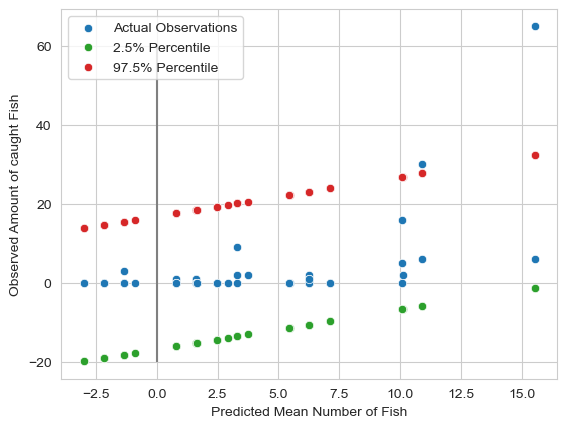

In [13]:
import seaborn as sns

lower_percentile = y_hat - 1.96 * std
upper_percentile = y_hat + 1.96 * std

sns.scatterplot(x=y_hat, y=yte, color="tab:blue", label="Actual Observations")
sns.scatterplot(x=y_hat, y=lower_percentile, color="tab:green", label="2.5% Percentile")
sns.scatterplot(x=y_hat, y=upper_percentile, color="tab:red", label="97.5% Percentile")

plt.vlines(0, -20, 60, colors="gray")

plt.legend()
plt.xlabel("Predicted Mean Number of Fish")
plt.ylabel("Observed Amount of caught Fish");

The Assumption of a gaussian distributed error is not sensible for count-data

#### e)
This data is count data. Count data has only positive values and also the distribution is discrete. You cannot catch 0.5 fish and that the CPD has probability density > 0 on negative number of fish is wrong too. A Gaussian as a CPD is therefore not ideal.

Now use a Poissonian as CPD. If we assume a Poissonian then the probability to catch fish is given by:
$$p(k) = exp(-\mu)\frac{\mu^{k}}{k!}$$
and the NLL is thus by:
$$log(p(k)) = -\mu + k * log(\mu) - log(k!)$$
with $\mu$ being the expectation. In our case the average number of fish expected.

In the case of the probabilistic interpretation of the linear regression, $y_{i}$ for a given $x_{i}$ is distributed like a Gaussian. The parameter $\mu_{i}$ from $N(\mu_{i}, \sigma^{2})$ has been determined from $x_{i}$ via $\mu_{i} = \beta ^{T} * x_{i}$ by minimizing the NLL.

A small additional detail: For the Poissonian case, $\mu_{i}$ needs to be positive. We therefore do not use $\beta^{T} * x_{i}$ directly but "pipe it through" an exponential first to make it positive and thus link $\mu_{i} = exp(\beta^{T} * x_{i})$ to the data.

Use a gradient descent approach on the NLL to find the solution for the parameters. Calculate the RMSE and the NLL on the test set and compare with c).

Hint: On the trainingset for the parameter values (1,1,1,1,1) the NLL should be approx 1508 and the gradient (1518.61, 1403.99, 1171.02, 5701.91, 3258.7). For the NLL a good learning rate would be 0.001 and training should be done for at least 5000 epochs.

In [14]:
def poisson_nll(y_true, y_hat):
    y_hat = tf.math.exp(y_hat)
    # exp(lgamma(n + 1)) == factorial(n)
    # Da der log von factorials benötigt wird, ist lgamma(n-1) ausreichend/effizienter
    factorials = tf.math.lgamma(y_true + 1)
    likelihoods = - y_hat + y_true * tf.math.log(y_hat) - factorials

    return - tf.reduce_mean(likelihoods)

In [15]:
x_train = tf.Variable(to_design_matrix(Xt), dtype="float64")
y_train = tf.Variable(yt, dtype="float64")

x_test = tf.Variable(to_design_matrix(Xte), dtype="float64")
y_test = tf.Variable(yte, dtype="float64")

beta = tf.Variable(np.ones((5, 1)), dtype="float64")

y_hat = tf.matmul(x_train, beta)

poisson_nll(y_train, y_hat)

<tf.Tensor: shape=(), dtype=float64, numpy=1510.1271602262084>

In [16]:
beta = tf.Variable(np.ones((5, 1)), dtype="float64")
learning_rate = 1e-3
for i in range(5000):
    with tf.GradientTape() as tape:
        y_hat = tf.matmul(x_train, beta)
        loss = poisson_nll(y_train, y_hat)
        gradients = tape.gradient(loss, beta)
        if i % 500 == 0 or i == 4999:
            print(f"Parameters at Iteration {i}: {beta.numpy().T}")
            print(f"Gradients at Iteration {i}: {gradients.numpy().T}")
            print(f"Negative Log-Likelihood at Iteration {i}: {loss:.2f}")
            print("-------------------------------------------------------")
        beta = tf.Variable(beta - learning_rate * gradients)

Parameters at Iteration 0: [[1. 1. 1. 1. 1.]]
Gradients at Iteration 0: [[1518.61304305 1404.40621631 1171.65947951 5704.75054653 3256.95861729]]
Negative Log-Likelihood at Iteration 0: 1510.13
-------------------------------------------------------
Parameters at Iteration 500: [[ 1.01348598  0.89330018  0.72645993 -0.64139242 -1.08651612]]
Gradients at Iteration 500: [[-1.31388772 -0.93842484 -0.45975212 -5.3991097  -2.13616412]]
Negative Log-Likelihood at Iteration 500: 9.93
-------------------------------------------------------
Parameters at Iteration 1000: [[ 0.8702186   0.62313661  0.40038854 -0.06892992 -0.41469441]]
Gradients at Iteration 1000: [[ 0.2993288   0.50896854  0.54072972 -0.26829292 -0.85442177]]
Negative Log-Likelihood at Iteration 1000: 6.99
-------------------------------------------------------
Parameters at Iteration 1500: [[ 0.785952    0.44586071  0.21575563  0.00340185 -0.14161887]]
Gradients at Iteration 1500: [[ 0.07133834  0.23766083  0.24019494 -0.0721847

In [18]:
poisson_beta_hat = beta.numpy()
y_hat = np.exp(to_design_matrix(Xte) @ poisson_beta_hat)

In [18]:
print(f"RMSE with Poissonian Error Distribution: {rmse(yte, y_hat):.4f}")

RMSE with Poissonian Error Distribution: 10.1256


In [19]:
print(f"NLL with Poissonian Error Distribution: {poisson_nll(y_test, y_hat):.4f}")

NLL with Poissonian Error Distribution: 25.0899


#### f)
Do the same plot as in d) but this time with a Poisson CPD. Hint you can use scipy.stats.poisson to calculate the percentiles.

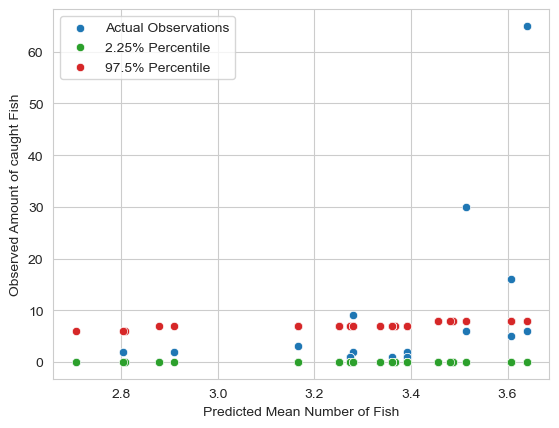

In [19]:
from scipy.stats import poisson

lower_percentile_pois = []
upper_percentile_pois = []

for mu in y_hat:
    poisson_dist = poisson(mu)
    lower_percentile_pois.append(poisson_dist.ppf(0.025)[0])
    upper_percentile_pois.append(poisson_dist.ppf(0.975)[0])

sns.scatterplot(x=y_hat[:, 0], y=yte, color="tab:blue", label="Actual Observations")
sns.scatterplot(x=y_hat[:, 0], y=lower_percentile_pois, color="tab:green", label="2.25% Percentile")
sns.scatterplot(x=y_hat[:, 0], y=upper_percentile_pois, color="tab:red", label="97.5% Percentile")

plt.legend()
plt.xlabel("Predicted Mean Number of Fish")
plt.ylabel("Observed Amount of caught Fish")
plt.show()

In [21]:
%load_ext version_information

In [22]:
%version_information numpy, matplotlib, seaborn, tensorflow

Software versions
Python 3.10.6 64bit [MSC v.1916 64 bit (AMD64)]
IPython 8.4.0
OS Windows 10 10.0.19044 SP0
numpy 1.23.3
matplotlib 3.5.2
seaborn 0.12.0
tensorflow 2.10.0
Sat Nov 12 10:26:47 2022 Mitteleuropäische Zeit